## Required imports

In [1]:
%matplotlib notebook

import os
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, HBox

import scipy.signal

import pyabf # see: https://github.com/swharden/pyABF

plt.ion()

ba = None # global bAnalysis object, used throughout this notebook

## Define a bAnalysis class

In [2]:
'''
The bAnalysis class wraps a pyabf file and adds spike detection and plotting.

Instantiate a bAnalysis object with a .abf file

The underlying pyabf object is always available as self.abf

Usage:
    ba = bAnalysis('data/19114001.abf')
    print(ba) # prints info about underlying abf file
    ba.plotDeriv()
    ba.spikeDetect(dVthresholdPos=100)
    ba.plotSpikes()
    ba.plotClips()
'''
class bAnalysis:
    def __init__(self, file=None):
        self.file = file
        self._abf = None
        self.spikeTimes = [] # created in self.spikeDetect()
        self.spikeClips = [] # created in self.spikeDetect()

        if not os.path.isfile(file):
            print('error: bAnalysis file does not exist "' + file + '""')
            return 0

        self._abf = pyabf.ABF(file)
    
        self.setSweep(0)
        
    ############################################################
    # access to underlying pyabf object (self.abf)
    ############################################################
    @property
    def abf(self):
        return self._abf

    def setSweep(self,sweepNumber):
        #todo: check that sweepNumber is in self.abf.sweepList
        self.abf.setSweep(sweepNumber)
        
    @property
    def sweepList(self):
        return self.abf.sweepList
    
    ############################################################
    # spike detection
    ############################################################
    def spikeDetect(self, dVthresholdPos=100):
        # check dvdt to select threshold for an action-potential
        sweepDeriv = np.diff(self.abf.sweepY)

        # scale it to V/S (mV/ms)
        sweepDeriv = sweepDeriv * self.abf.dataRate / 1000

        # add an initial point so it is the same length as raw data in abf.sweepY
        sweepDeriv=np.concatenate(([0],sweepDeriv))


        #spikeTimes = _where_cross(sweepDeriv,dVthresholdPos)
        Is=np.where(sweepDeriv>dVthresholdPos)[0]
        Is=np.concatenate(([0],Is))
        Ds=Is[:-1]-Is[1:]+1
        self.spikeTimes = Is[np.where(Ds)[0]+1]

        #print('original number of ap is:', len(self.spikeTimes))

        #
        # center APs on their positive dV peak and eliminate duplicates
        '''
        msInPeak = 5
        for i, pt in enumerate(spikeTimes):
            derivFast = sweepDeriv[pt:pt+abf.dataPointsPerMs*msInPeak]
            ptMax = np.max(derivFast)
            spikeTimes[i] = pt + np.where(derivFast==ptMax)[0][0]
        spikeTimes = sorted(list(set(spikeTimes)))
        '''

        #
        # throw out crossings which don't go negative after 4ms
        '''
        dVthresholdNeg = -dVthresholdPos/2
        for i, pt in enumerate(spikeTimes):
            derivFast = sweepDeriv[pt:pt+abf.dataPointsPerMs*2]
            if np.min(derivFast)>dVthresholdNeg:
                spikeTimes[i]=0
        spikeTimes = [x for x in spikeTimes if x]
        '''

        #
        # if there are doubles, throw-out the second one
        if 1:
            refractory_ms = 10
            lastGood = 0 # index [i] of last good, first crossing will always be good
            for i in range(len(self.spikeTimes)):
                if i==0:
                    continue
                #dPoints = spikeTimes[i] - spikeTimes[i-1]
                dPoints = self.spikeTimes[i] - self.spikeTimes[lastGood]
                if dPoints < self.abf.dataPointsPerMs*refractory_ms:
                    #print('remove i:', i, 'dPoints:', dPoints, 'spikeTimes[i]:', spikeTimes[i])
                    self.spikeTimes[i] = 0
                else:
                    #print('keep i:', i, 'dPoints:', dPoints, 'spikeTimes[i]:', spikeTimes[i])
                    lastGood = i
            self.spikeTimes = [x for x in self.spikeTimes if x]

        print('detected ', len(self.spikeTimes), 'spikes')

        #
        # build up a list of spike clips
        clipWidth_ms = 100
        clipWidth_pnts = clipWidth_ms * self.abf.dataPointsPerMs
        halfClipWidth_pnts = int(clipWidth_pnts/2)

        # make one x axis clip with the threshold crossing at 0
        self.spikeClips_x = [(x-halfClipWidth_pnts)/self.abf.dataPointsPerMs for x in range(clipWidth_pnts)]

        self.spikeClips = []
        for spikeTime in self.spikeTimes:
            currentClip = self.abf.sweepY[spikeTime-halfClipWidth_pnts:spikeTime+halfClipWidth_pnts]
            self.spikeClips.append(currentClip)

    @property
    def numSpikes(self):
        '''
        Returns the number of spikes, assumes self.spikeDetect(dVthreshold)
        '''
        return len(self.spikeTimes)

    #############################
    # plot functions
    #############################
    def plotDeriv(self):
        '''
        Plot the derivative of Vm. Plots both raw and median filtered.
        '''
        
        vm = self.abf.sweepY
        vmFiltered = scipy.signal.medfilt(self.abf.sweepY,3)

        sweepDeriv = np.diff(vm)
        sweepDerivFiltered = np.diff(vmFiltered)

        # scale it to V/S (mV/ms)
        sweepDeriv = sweepDeriv * self.abf.dataRate / 1000
        sweepDerivFiltered = sweepDerivFiltered * self.abf.dataRate / 1000

        # add an initial point so it is the same length as raw data in abf.sweepY
        sweepDeriv = np.concatenate(([0],sweepDeriv))
        sweepDerivFiltered = np.concatenate(([0],sweepDerivFiltered))

        grid = plt.GridSpec(4, 1, wspace=0.2, hspace=0.4)
        
        fig = plt.figure()
        ax1 = fig.add_subplot(grid[0,0])
        ax2 = fig.add_subplot(grid[1,0], sharex=ax1)
        ax3 = fig.add_subplot(grid[2,0], sharex=ax1)
        ax4 = fig.add_subplot(grid[3,0], sharex=ax1)


        ax1.plot(vm)
        ax1.set_ylabel('Vm (mV)')

        ax2.plot(sweepDeriv)
        ax2.set_ylabel('dV/dt')

        ax3.plot(vmFiltered)
        ax3.set_ylabel('Filtered Vm (mV)')

        ax4.plot(sweepDerivFiltered)
        ax4.set_ylabel('filtered dV/dt')
 

    def plotSpikes(self, all=True, oneSpikeNumber=None, ax=None):
        '''
        Plot Vm with a detected spikes overlaid
        '''
        if ax is None:
            grid = plt.GridSpec(1, 1, wspace=0.2, hspace=0.4)

            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(grid[0, 0:]) #Vm, entire sweep
        
        # plot vm
        ax.plot(self.abf.sweepX, self.abf.sweepY, 'k')

        # plot all spike times
        for spikeTime in self.spikeTimes:
            ax.plot(self.abf.sweepX[spikeTime], self.abf.sweepY[spikeTime], 'og')

        # plot one spike time as a red circle
        line = None
        if oneSpikeNumber is not None:
            oneSpikeTime = self.spikeTimes[oneSpikeNumber]
            line, = ax.plot(self.abf.sweepX[oneSpikeTime], self.abf.sweepY[oneSpikeTime], 'or')

        ax.set_ylabel('Vm (mV)')
        ax.set_xlabel('Time (sec)')

        return line
    
    def plotClips(self, oneSpikeNumber=None, ax=None):
        '''
        Plot clips of all detected spikes
        
        Clips are created in self.spikeDetect() and default to clipWidth_ms = 100 ms
        '''
        if ax is None:
            grid = plt.GridSpec(1, 1, wspace=0.2, hspace=0.4)

            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(grid[0, 0:]) #Vm, entire sweep

        for i in range(len(self.spikeClips)):
            ax.plot(self.spikeClips_x, self.spikeClips[i], 'k')

        # plot current clip
        line = None
        if oneSpikeNumber is not None:
            line, = ax.plot(self.spikeClips_x, self.spikeClips[oneSpikeNumber], 'r')

        ax.set_ylabel('Vm (mV)')
        ax.set_xlabel('Time (ms)')

        return line

    ############################################################
    # utility
    ############################################################
    def __str__(self):
        retStr = 'file: ' + self.file + '\n' + str(self.abf)
        return retStr

## Load an abf file

In [4]:
path = 'data'
files = os.listdir(path)

fileList = widgets.Select(
    options=files,
    # rows=10,
    description='fileList',
    disabled=False
)

def loadButton_callback(b):
    file = os.path.join('data', fileList.value)
    
    global ba
    ba = bAnalysis(file)
    
loadButton = widgets.Button(
    description='Load',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Load selected file'
)

loadButton.on_click(loadButton_callback)

HBox(children=[fileList, loadButton])



## Check the derivative of Vm (dV/dt) to select threshold for spike detection.

<IPython.core.display.Javascript object>


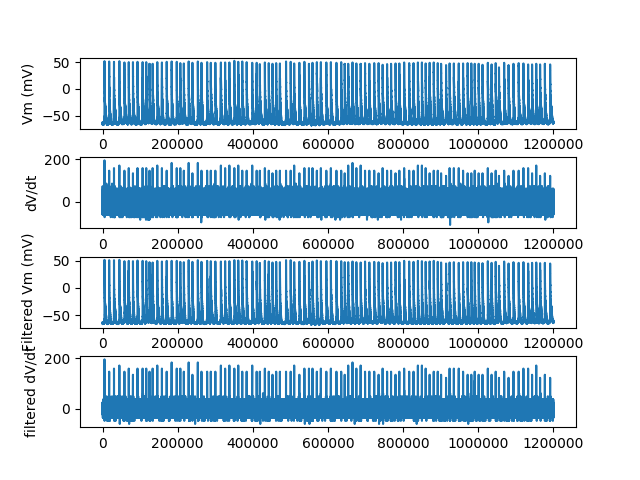

In [5]:
ba.plotDeriv()

## Run spike detection with myThreshold and plot results

detected  103 spikes


<IPython.core.display.Javascript object>


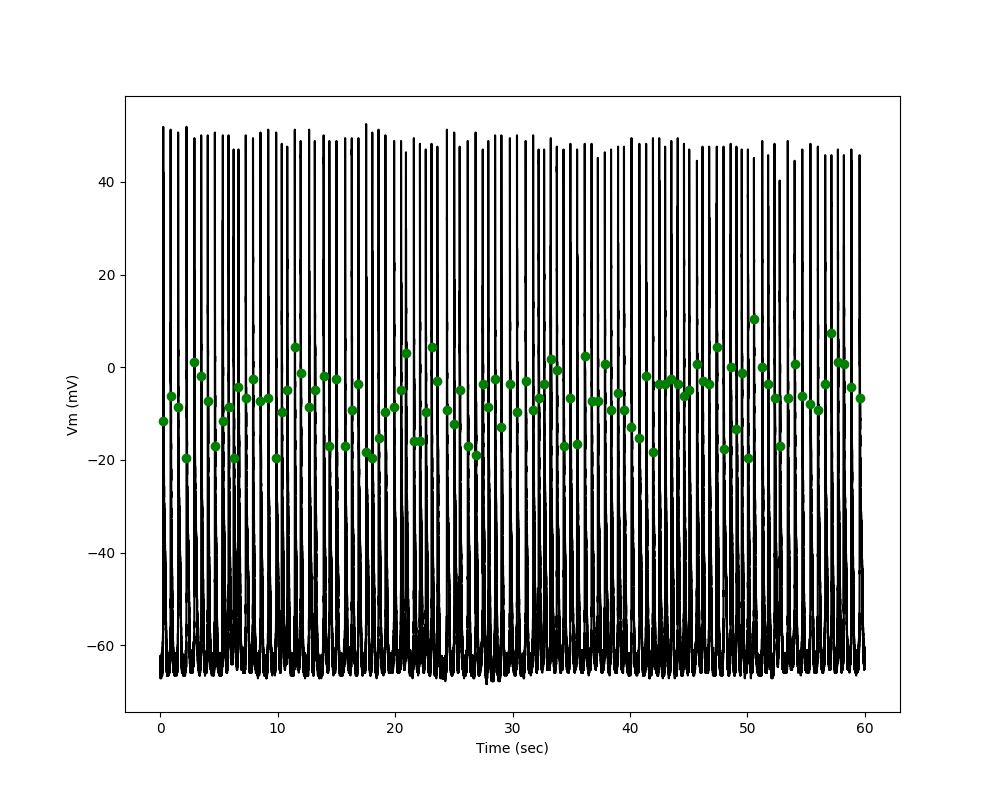

In [6]:
myThreshold = 100
ba.spikeDetect(dVthresholdPos=myThreshold)
ba.plotSpikes()

## Make a spike browser

<IPython.core.display.Javascript object>


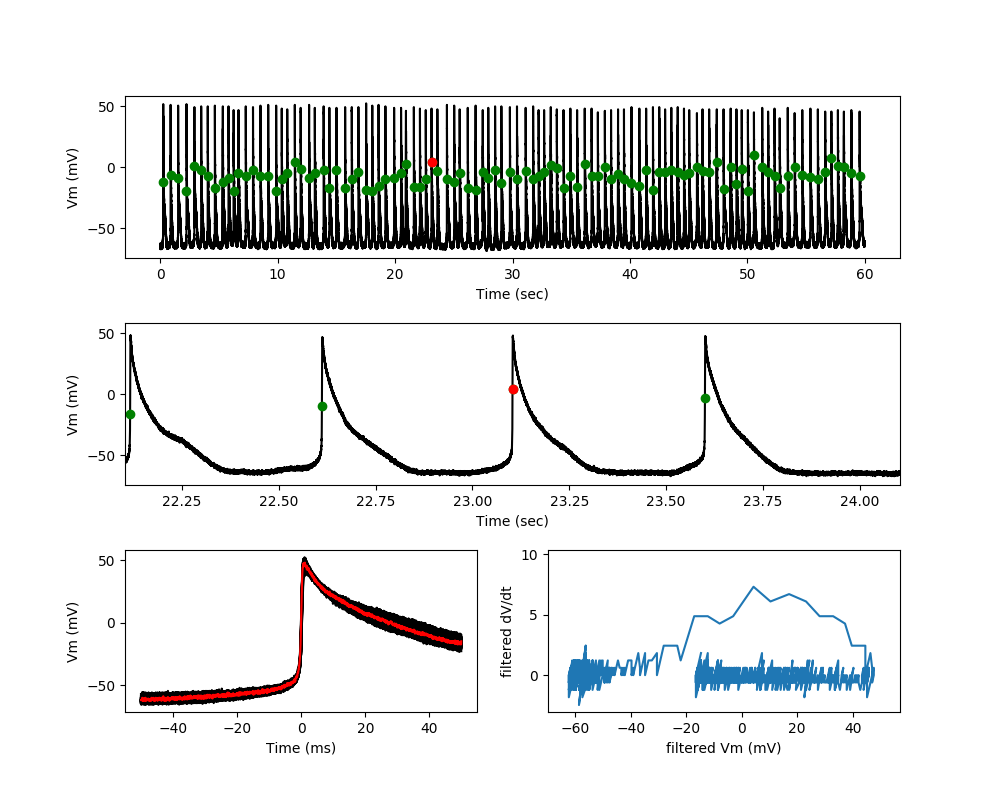

In [7]:
currentSpikeNumber = 0

#
# make a figure with subplots and plot it once
grid = plt.GridSpec(3, 2, wspace=0.2, hspace=0.4)

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(grid[0, 0:]) #Vm, entire sweep
ax3 = fig.add_subplot(grid[1, 0:]) #Vm, middle zoom
ax2 = fig.add_subplot(grid[2, 0]) #Vm, spike clip
ax4 = fig.add_subplot(grid[2, 1]) #phase plot

#
# plot vm
line1 = ba.plotSpikes(oneSpikeNumber=currentSpikeNumber, ax=ax1)

#
# plot middle view with intermediate x-axis
line3 = ba.plotSpikes(oneSpikeNumber=currentSpikeNumber, ax=ax3)

#
# plot all clips
line2 = ba.plotClips(oneSpikeNumber=currentSpikeNumber, ax=ax2)

#
# plot one spike phase plot
# filter spike clip
filteredClip = scipy.signal.medfilt(ba.spikeClips[currentSpikeNumber],3)
dvdt = np.diff(filteredClip)
# add an initial point so it is the same length as raw data in abf.sweepY
dvdt = np.concatenate(([0],dvdt))
line4, = ax4.plot(filteredClip, dvdt)

ax4.set_ylabel('filtered dV/dt')
ax4.set_xlabel('filtered Vm (mV)')

fig.show()
fig.canvas.draw()


def updatePlot(spikeNumber):
    ''' When called as an ipywidget callback, spikeNumber is a dicitonary !!!'''
    if isinstance(spikeNumber, dict):
        spikeNumber = spikeNumber['new']
    
    global currentSpikeNumber
    currentSpikeNumber = spikeNumber
    
    # plot one spike (red circle)
    line1.set_xdata(ba.abf.sweepX[ba.spikeTimes[spikeNumber]])
    line1.set_ydata(ba.abf.sweepY[ba.spikeTimes[spikeNumber]])

    # plot one spike clip
    line2.set_ydata(ba.spikeClips[spikeNumber])

    # intermediate (x-axis) plot
    minTime = ba.abf.sweepX[ba.spikeTimes[spikeNumber]] - 1
    maxTime = ba.abf.sweepX[ba.spikeTimes[spikeNumber]] + 1
    ax3.axes.set_xlim(minTime, maxTime)
    line3.set_xdata(ba.abf.sweepX[ba.spikeTimes[spikeNumber]])
    line3.set_ydata(ba.abf.sweepY[ba.spikeTimes[spikeNumber]])
    
    # phase plot
    filteredClip = scipy.signal.medfilt(ba.spikeClips[spikeNumber],3)
    dvdt = np.diff(filteredClip)
    # add an initial point so it is the same length as raw data in abf.sweepY
    dvdt = np.concatenate(([0],dvdt))
    line4.set_xdata(filteredClip)
    line4.set_ydata(dvdt)
    
    fig.canvas.draw()
    
mySlider = widgets.IntSlider(
    min=0,
    max=ba.numSpikes-1,
    step=1,
    description='Spike Number',
    value=0,
    continuous_update=False)
mySlider.observe(updatePlot, names='value')

def on_slider_change(change):
    updatePlot(change['new'])
    
def myButton_prev_callback(b):
    global currentSpikeNumber
    currentSpikeNumber -= 1
    if currentSpikeNumber < 0:
        currentSpikeNumber = 0
    mySlider.value = currentSpikeNumber # mySlider will do an update

myButton_prev = widgets.Button(
    description='Previous',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Go to previous spike'
)
myButton_prev.on_click(myButton_prev_callback)


def myButton_next_callback(b):
    global currentSpikeNumber
    currentSpikeNumber += 1
    if currentSpikeNumber > ba.numSpikes - 1:
        currentSpikeNumber = ba.numSpikes - 1
    mySlider.value = currentSpikeNumber # mySlider will do an update

myButton_next = widgets.Button(
    description='Next',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Go to next spike'
)
myButton_next.on_click(myButton_next_callback)


# initial plot
updatePlot(spikeNumber=0)

# display the controls horizontally
HBox(children=[mySlider, myButton_prev, myButton_next])